In [29]:
''' Import feature tools library and numpy, pandas, sklearn modules and libraries'''
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.decomposition import PCA 
import featuretools as ft
from xgboost import XGBClassifier
# Classification metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import cohen_kappa_score
# Ignore ConvergenceWarning messages
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.simplefilter(action='ignore', category=ConvergenceWarning)

In [30]:
def train_application():
        
    """
    This function reads application_train.csv, cleans it and perform manual feature engineering for each
    application (SK_ID_CURR).   
    
    Parameters:
    None

    Returns:
    train: training dataFrame which includes hand engineered features from 
                  just application_train table.   
    
    """
    
    print('Processing application_train and application_test tables')
    train = pd.read_csv('application_train.csv')
    # Delete four applications with XNA CODE_GENDER (train set)
    train = train[train['CODE_GENDER'] != 'XNA']
    # Replace DAYS_EMPLOYED = 365243 by nan
    train['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True) 
    # Feature engineering
    train['Days_employed_age']   = train['DAYS_EMPLOYED'] / train['DAYS_BIRTH']
    train['Credit_income_ratio'] = train['AMT_CREDIT'] / train['AMT_INCOME_TOTAL']
    train['Anuity_income_ratio'] = train['AMT_ANNUITY'] / train['AMT_INCOME_TOTAL'] 
    train['Income_per_person']   = train['AMT_INCOME_TOTAL'] / train['CNT_FAM_MEMBERS']
    #length of the payment in months since the annuity is the monthly amount due
    train['Credit_term'] = train['AMT_ANNUITY']/train['AMT_CREDIT'] 
   
    return train

In [31]:
def Automated_features(train, nrows, max_depth):
    
    ''' 
    Automated feature engineering is conducted on all the tables using feature tools.
    
    Parameters:
    train: preprocessed training data 
    nrows: number of rows considered in train data for the model due to the computational power limitation.
    max_depth: depth of a deep feature is the number of primitives required to make the feature.

    Returns:
    train_ft: train dataframe with added new features from automated feature engineering.  
    
    '''
    bureau    = pd.read_csv('bureau.csv')
    bureaubal = pd.read_csv('bureau_balance.csv')
    prev      = pd.read_csv('previous_application.csv')
    ccb       = pd.read_csv('credit_card_balance.csv')
    insta     = pd.read_csv('installments_payments.csv')
    pc        = pd.read_csv('POS_CASH_balance.csv')

    # Choosing nrows data from all datasets
    train = train.sample(frac=1)
    train = train[:nrows]
    ids = train['SK_ID_CURR'].values
    bureau = bureau.loc[bureau['SK_ID_CURR'].isin(ids)]
    idsb = bureau['SK_ID_BUREAU'].values
    bureaubal = bureaubal.loc[bureaubal['SK_ID_BUREAU'].isin(idsb)]
    prev = prev.loc[prev['SK_ID_CURR'].isin(ids)]
    ccb  = ccb.loc[ccb['SK_ID_CURR'].isin(ids)]
    insta = insta.loc[insta['SK_ID_CURR'].isin(ids)]
    pc   = pc.loc[pc['SK_ID_CURR'].isin(ids)]

    # creating EntitySet (collection of tables)
    es = ft.EntitySet(id = 'applications')
    # adding Entity (table) to EntitySet
    es = es.entity_from_dataframe(entity_id = 'train'    , dataframe = train    , index= 'SK_ID_CURR')
    es = es.entity_from_dataframe(entity_id = 'bureau'   , dataframe = bureau   , index= 'SK_ID_BUREAU')
    es = es.entity_from_dataframe(entity_id = 'bureaubal', dataframe = bureaubal, make_index = True, index = 'bb_id')
    es = es.entity_from_dataframe(entity_id = 'prev'     , dataframe = prev     , index = 'SK_ID_PREV')
    es = es.entity_from_dataframe(entity_id = 'ccb'      , dataframe = ccb      , make_index = True, index = 'cc_id')
    es = es.entity_from_dataframe(entity_id = 'insta'    , dataframe = insta    , make_index = True, index = 'installment.id')
    es = es.entity_from_dataframe(entity_id = 'pc'       , dataframe = pc       , make_index = True, index = 'pos_cash_id')
    # Creating relation between Entities
    # Relationship between application training and bureau
    r_applications_bureau = ft.Relationship(es['train']['SK_ID_CURR'], es['bureau']['SK_ID_CURR'])
    es = es.add_relationship(r_applications_bureau)
    # Relationship between bureau and bureau balance
    r_bureau_bureaubal = ft.Relationship(es['bureau']['SK_ID_BUREAU'], es['bureaubal']['SK_ID_BUREAU'])
    es = es.add_relationship(r_bureau_bureaubal)
    # Relationship between application training and previous applications
    r_app_prev = ft.Relationship(es['train']['SK_ID_CURR'], es['prev']['SK_ID_CURR'])
    es = es.add_relationship(r_app_prev)
    # Relationship between previous applications with credit card balance, pos cash, and installments
    r_prev_cc = ft.Relationship(es['prev']['SK_ID_PREV'], es['ccb']['SK_ID_PREV'])
    es = es.add_relationship(r_prev_cc)
    r_prev_insta = ft.Relationship(es['prev']['SK_ID_PREV'], es['insta']['SK_ID_PREV'])
    es = es.add_relationship(r_prev_insta)
    r_prev_pc2 = ft.Relationship(es['prev']['SK_ID_PREV'], es['pc']['SK_ID_PREV'])
    es = es.add_relationship(r_prev_pc2)
    print('EntitySet with Relationships', es)
    # Deep feature synthesis with depth of 2 by stacking feature primitives (agregations and tranformations)
    # Automated features are concatenated to the original features; Therefore, 
    train_ft, feature_names = ft.dfs(entityset = es, target_entity = 'train', max_depth = max_depth)
    train_ft = train_ft.reset_index()
    print('\nTotal number of features after adding automated features: ', train_ft.shape[1])
    return train_ft

In [32]:
def preprocessing(train):
    '''
    This function calculates the correlation between all features in training data and drops the columns with 
    correlation > 0.98. Then, it encodes categorical features and save them as 'category' type for lightGBM algorithms.

    Parameters:
    train: trainig sets after with automated features from feature tools.

    Returns:
    train: pandas.DataFrame which includes preprocessed training dataset.
    '''

    print('Preprocessing final table and one-hot encoding categorical features...')
    # Drop the columns with correlation > 0.98
    corr = train.corr()
    upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(np.bool))
    to_drop = [column for column in upper.columns if any(upper[column] > 0.98)]
    train = train.drop(to_drop, axis=1)
    
    # Imputating the missing data, PCA can not handle missing data
    # Missing categorical features are imputed with 'Not_applicable'
    # Missing numeric features are imputed with Zero (logical choice for this dataset)
    cols = train.select_dtypes(include = object).columns
    train[cols] = train[cols].fillna('Not_Applicable')
    cols = train.select_dtypes(exclude = object).columns
    train[cols] = train[cols].fillna(0)
    
    # One-hot encoding categorical features for XGBoost algorithm. 
    train = pd.get_dummies(train, drop_first=True)
    
    return train

In [33]:
def XGBoost(train, num_folds, test_size):
    '''
    This function train a machine learning model using XGBoost algorithm. 

    Parameters:
    train: preprocessed training data 
    num_folds: number of folds for cross-validation (default is 5)
    test_size: ratio of train to test dataset

    Returns:
    pred_class: Binary class prediction of the target variable.
    pred: Probability prediction of the target variable.
    y_test: y_test in the trainig dataset
    '''
    
    # Train and test set split
    y = train['TARGET']
    X = train.drop('TARGET', axis=1)
    X_train, X_test, y_train, y_test = train_test_split(X, y , test_size = test_size, random_state=1234)
    
    # First 200 principle components are used for XGBoost 
    # PCA requires standardization of featuers
    sc = StandardScaler()
    X_pca = sc.fit_transform(X_train)
    pca = PCA(n_components = 200)
    X_pca = pca.fit_transform(X_pca)
    print('\nRatio of variance explained by 200 principal components: ', sum(pca.explained_variance_ratio_))
    
    pipeline = make_pipeline(StandardScaler(),PCA(n_components = 200), XGBClassifier())

    params = {
              'xgbclassifier__learning_rate': [0.05, 0.1, 0.15, 0.2],
              'xgbclassifier__max_depth': [3, 4, 5, 6, 8, 10 ],
              'xgbclassifier__min_child_weight': [1, 3, 5, 7], 
              'xgbclassifier__gamma' : [0, 0.1, 0.2, 0.3, 0.4],   
              'xgbclassifier__colsample_bytree': [ 0.5, 0.7, 1]            
              }
    print('\nApplying XGBoost classifier... \n')
    
    model = RandomizedSearchCV(pipeline, params, n_iter=4, scoring='roc_auc', cv=5, n_jobs=-1, verbose = 3)
    model.fit(X_train, y_train)
    print('\nCross validation best score(AUC) is:', model.best_score_)
    # Hyperparameters of the model with the best performance
    print('\nModel best hyperparamters are:', model.best_params_)
    # Binary class prediction
    pred_class = model.predict(X_test)
    # Probability prediction
    pred = model.predict_proba(X_test)
    pred = [p[1] for p in pred]
    return pred_class, pred, y_test

In [34]:
def calculate_metrics(pred_class, pred, y_test):
    '''
    This function calculates the classificaiton metrics including precision, recall, F1-Score, AUC_ROC, and cohen-kappa coefficient.

    Parameters:
    pred_class: Binary class prediction of the target variable.
    pred: Probability prediction of the target variable.
    y_test: y_test in the trainig dataset

    Returns:
    None
    '''

    # ROC_AUC score
    print('ROC_AUC:', roc_auc_score(y_test, pred))
    # Precision/Recall (0.1 Threshold)
    pred_class_2 = (np.array(pred) > 0.1).astype(int)
    cm = confusion_matrix(y_test, pred_class_2)
    print('\nConfusion_metrix (0.1 Threshold): \n', cm)
    # True Negatives (TN)
    tn = cm[0][0]
    # False Positives (FP)
    fp = cm[0][1]    
    # False Negatives (FN)
    fn = cm[1][0]
    # True Positives (TP)
    tp = cm[1][1]
    precision = tp / (tp + fp)
    print( 'Precision (0.1 Threshold): ', precision )
    recall = tp / (tp + fn)
    print( 'Recall (0.1 Threshold): ', recall )
    print( 'F1-score ( 0.1 Threshold):', 2*precision*recall/(precision+recall))
    cohen_kappa = cohen_kappa_score(y_test, pred_class_2)
    print( '\nCohen_kappa (0.1 Threshold): ', cohen_kappa )

def plot_ROC(y_test, pred):
    '''
    This function plots ROC based on y_test and predictied probability of positive class by lightGBM.

    Parameters:
    pred: Probability prediction of the target variable.
    y_test: y_test in the trainig dataset

    Returns:
    None
    '''
    # Initialize figure
    fig = plt.figure(figsize=(9,9))
    plt.title('Receiver Operating Characteristic')
    # Plot ROC curve
    fpr, tpr, thresholds = roc_curve(y_test, pred)
    plt.plot(fpr, tpr)
    # Diagonal 45 degree line
    plt.plot([0,1],[0,1],'k--')
    # Axes limits and labels
    plt.xlim([-0.1,1.1])
    plt.ylim([-0.1,1.1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

def plot_precision_recall(y_test, pred):
    '''
    This function plots precicision_recall curve based on y_test and predictied probability of positive class by lightGBM..

    Parameters:
    pred: Probability prediction of the target variable.
    y_test: y_test in the trainig dataset
    
    Returns:
    None
    '''
    precision, recall, thresholds = precision_recall_curve(y_test, pred)
    fig = plt.figure(figsize=(9,9))
    plt.title('Precision_Recall')
    # Plot Precision-Recall curve
    plt.plot(recall, precision)
    # Axes limits and labels
    plt.xlim([0,1])
    plt.ylim([0,1])
    plt.ylabel('Precision')
    plt.xlabel('Recall')
    plt.show()

Processing application_train and application_test tables
EntitySet with Relationships Entityset: applications
  Entities:
    train [Rows: 30000, Columns: 127]
    bureau [Rows: 86286, Columns: 17]
    bureaubal [Rows: 911993, Columns: 4]
    prev [Rows: 138560, Columns: 37]
    ccb [Rows: 84931, Columns: 24]
    insta [Rows: 1125445, Columns: 9]
    pc [Rows: 86293, Columns: 9]
  Relationships:
    bureau.SK_ID_CURR -> train.SK_ID_CURR
    bureaubal.SK_ID_BUREAU -> bureau.SK_ID_BUREAU
    prev.SK_ID_CURR -> train.SK_ID_CURR
    ccb.SK_ID_PREV -> prev.SK_ID_PREV
    insta.SK_ID_PREV -> prev.SK_ID_PREV
    pc.SK_ID_PREV -> prev.SK_ID_PREV

Total number of features after adding automated features:  2226
Preprocessing final table and one-hot encoding categorical features...

Ratio of variance explained by 200 principal components:  0.7023963403648208

Applying XGBoost classifier... 

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  8.2min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  8.2min finished



Cross validation best score(AUC) is: 0.6735569039652113

Model best hyperparamters are: {'xgbclassifier__min_child_weight': 5, 'xgbclassifier__max_depth': 3, 'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__gamma': 0.4, 'xgbclassifier__colsample_bytree': 0.7}
ROC_AUC: 0.6674257906376042

Confusion_metrix (0.1 Threshold): 
 [[1025  354]
 [  59   62]]
Precision (0.1 Threshold):  0.14903846153846154
Recall (0.1 Threshold):  0.512396694214876
F1-score ( 0.1 Threshold): 0.23091247672253257

Cohen_kappa (0.1 Threshold):  0.12106215984609003


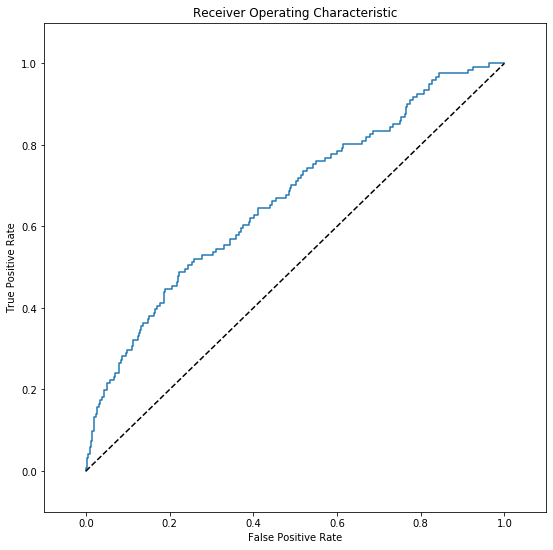

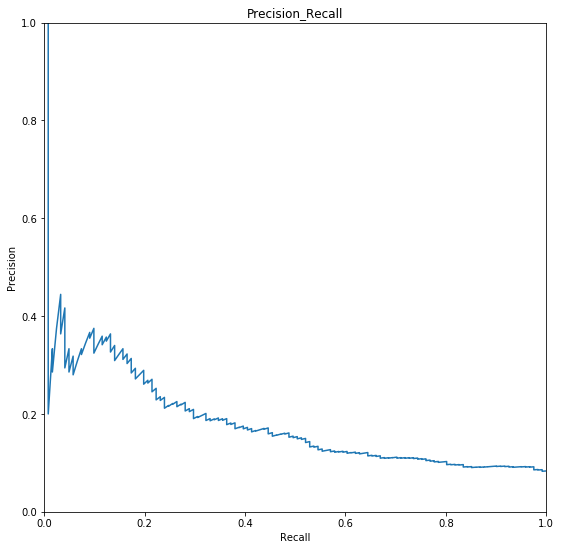

In [35]:
''' -------------------------------Main---------------------------
The main calls all funcitons sequentillay, apply automated feature engineering, train XGBoost, and plot the classification metrics.
    
'''
# 1) Model performance with concatenating CNN features
train = train_application()

# Extract new features using feature tools
# max_depth: depth of a deep feature is the number of primitives required to make the feature.
max_depth = 2

# nrows: number of rows considered in train data for the model due to the computational power limitation.
nrows = 30000

train = Automated_features(train, nrows, max_depth)

# Preprocesing including one hot encoding of categorical varibles for XGBoost 
train = preprocessing(train)

# Training XGBoost
nfolds = 5
test_size = 0.05
pred_class, pred, y_test = XGBoost(train, nfolds, test_size)
# Evalutate ROC_AUC, Precision, Recall, F1-Score, Kohen-Cappa metrics
calculate_metrics(pred_class, pred, y_test)
# Plot ROC curve
plot_ROC(y_test, pred)
# Plot Precision/R curve
plot_precision_recall(y_test, pred)